<a href="https://colab.research.google.com/github/Eezzeldin/POC/blob/main/Profit_ML_V4_run4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install gplearn

In [ ]:
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Generating some synthetic data for demonstration
# For example, let's try to discover the relationship y = x^2 - x + 1
X = np.linspace(-1, 1, 100).reshape(-1, 1)
y = X**2 - X + 1 + np.random.randn(*X.shape) * 0.1

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and training the symbolic regressor
est_gp = SymbolicRegressor(population_size=5000,
                           generations=3, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0 ,n_jobs=-1)
est_gp.fit(X_train, y_train)

# Making predictions
y_pred = est_gp.predict(X_test)

# Evaluating the model
print("Model expression:", est_gp._program)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    48.81          10318.3       63         0.184254         0.200621     29.91s
   1    12.62          27.0809       19          0.13344         0.195694     10.50s
   2     8.86          3.00229        7        0.0741519        0.0676914      0.00s
Model expression: add(mul(X0, X0), sub(0.966, X0))
Mean Squared Error: 0.017524527396474976


In [ ]:
import pandas as pd
import numpy as np

import random

from gplearn.genetic import SymbolicRegressor, SymbolicTransformer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt

In [ ]:
'''
+The reason an MMC  has the Profit it does is :
- price, TIV decay
- R2 TIV , R2 Price

- Confidence measure : number of points.

- Year of Release (candidate for removal)

+missing from analysis :
TIV Launch price

+grouping variable    : Launch Price Bins.
+granularity variable : MMC
'''

'\n+The reason an MMC  has the Profit it does is :\n- price, TIV decay\n- R2 TIV , R2 Price\n\n- Confidence measure : number of points.\n\n- Year of Release (candidate for removal)\n\n+missing from analysis :\nTIV Launch price\n\n+grouping variable    : Launch Price Bins.\n+granularity variable : MMC\n'

In [ ]:
input_file_path    = "/content/profit_pred_3.csv"

col_rename_dict = {
    "Launch Price (bin)"   : "LPB" ,
    'Avg. Launch Price'    : "LP"  ,
    "Avg. Launch TIV"      : "LTIV",
    "Model Memory Carrier" : "MMC" ,
    "Year of Release Date" : "Year",
    "Avg. Point Count 1000": "PC"  ,
    "Avg. Price decay"     : "Price_Decay",
    "Avg. Price rsquared"  : "Price_R2"  ,
    "Avg. TIV decay"       : "TIV_Decay" ,
    "Avg. TIV rsquared"    : "TIV_R2",
}

not_Features           = ["Profit" , "MMC" , "Year"]
Target                 = "Profit"
pred_col_name          = "Profit_Pred"

scaler_dict            = {}
interaction_1_name     = "Price_Decay_R2"
interaction_1_terms    = ["Price_R2" , "Price_Decay"]

grouping_col           = "LPB" # .astype("category")

number_of_test_per_fold = 1
fold_y_pred             = "fold_y_pred"
fold_test_index         = "fold_test_index"
fold_num                = 'fold_num'

interaction       = False
one_hot           = False
scale_features    = True
drop_grouping_var = True

In [ ]:
data_input  = pd.read_csv (input_file_path)
data_input.head ()

,Launch Price (bin),Model Memory Carrier,Year of Release Date,Avg. Launch Price,Avg. Launch TIV,Avg. Point Count 1000,Avg. Price decay,Avg. Price rsquared,Avg. TIV decay,Avg. TIV rsquared,Profit
0,1000,iPhone XS Max_512GB_Verizon,2018,1029.35,656.816,19,-0.001192,0.894662,-0.001335,0.879887,41381
1,1000,iPhone XS Max_512GB_Unlocked,2018,1014.39,634.388,20,-0.001009,0.911918,-0.001326,0.918513,227473
2,1000,iPhone XS Max_256GB_Unlocked,2018,1008.15,602.997,20,-0.001031,0.915380,-0.001333,0.932912,1514777
3,1000,iPhone X_256GB_Verizon,2017,1011.38,602.270,19,-0.001220,0.958448,-0.001388,0.895701,126462
4,900,iPhone XS Max_256GB_Verizon,2018,982.38,562.836,20,-0.001070,0.891031,-0.001114,0.860168,199737


In [ ]:
data_input.shape

(114, 11)

In [ ]:
data_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Launch Price (bin)     114 non-null    int64  
 1   Model Memory Carrier   114 non-null    object 
 2   Year of Release Date   114 non-null    int64  
 3   Avg. Launch Price      114 non-null    float64
 4   Avg. Launch TIV        114 non-null    float64
 5   Avg. Point Count 1000  114 non-null    int64  
 6   Avg. Price decay       114 non-null    float64
 7   Avg. Price rsquared    114 non-null    float64
 8   Avg. TIV decay         114 non-null    float64
 9   Avg. TIV rsquared      114 non-null    float64
 10  Profit                 114 non-null    int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 9.9+ KB


In [ ]:
data_input.columns

Index(['Launch Price (bin)', 'Model Memory Carrier', 'Year of Release Date',
       'Avg. Launch Price', 'Avg. Launch TIV', 'Avg. Point Count 1000',
       'Avg. Price decay', 'Avg. Price rsquared', 'Avg. TIV decay',
       'Avg. TIV rsquared', 'Profit'],
      dtype='object')

In [ ]:
data_input.rename (col_rename_dict,axis =1 ,inplace=True)
data_input.head()

,LPB,MMC,Year,LP,LTIV,PC,Price_Decay,Price_R2,TIV_Decay,TIV_R2,Profit
0,1000,iPhone XS Max_512GB_Verizon,2018,1029.35,656.816,19,-0.001192,0.894662,-0.001335,0.879887,41381
1,1000,iPhone XS Max_512GB_Unlocked,2018,1014.39,634.388,20,-0.001009,0.911918,-0.001326,0.918513,227473
2,1000,iPhone XS Max_256GB_Unlocked,2018,1008.15,602.997,20,-0.001031,0.915380,-0.001333,0.932912,1514777
3,1000,iPhone X_256GB_Verizon,2017,1011.38,602.270,19,-0.001220,0.958448,-0.001388,0.895701,126462
4,900,iPhone XS Max_256GB_Verizon,2018,982.38,562.836,20,-0.001070,0.891031,-0.001114,0.860168,199737


In [ ]:
data_input [grouping_col] = data_input [grouping_col].astype("category")

In [ ]:
#data_input [interaction_1_name] = data_input [interaction_1_terms [0]]  * data_input [interaction_1_terms [1]]

In [ ]:
X = data_input.drop (not_Features , axis=1)
y =  data_input [Target]

In [ ]:
X.head ( )

,LPB,LP,LTIV,PC,Price_Decay,Price_R2,TIV_Decay,TIV_R2
0,1000,1029.35,656.816,19,-0.001192,0.894662,-0.001335,0.879887
1,1000,1014.39,634.388,20,-0.001009,0.911918,-0.001326,0.918513
2,1000,1008.15,602.997,20,-0.001031,0.915380,-0.001333,0.932912
3,1000,1011.38,602.270,19,-0.001220,0.958448,-0.001388,0.895701
4,900,982.38,562.836,20,-0.001070,0.891031,-0.001114,0.860168


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   LPB          114 non-null    category
 1   LP           114 non-null    float64 
 2   LTIV         114 non-null    float64 
 3   PC           114 non-null    int64   
 4   Price_Decay  114 non-null    float64 
 5   Price_R2     114 non-null    float64 
 6   TIV_Decay    114 non-null    float64 
 7   TIV_R2       114 non-null    float64 
dtypes: category(1), float64(6), int64(1)
memory usage: 6.8 KB


In [ ]:
for col in X.columns :
  try :
    #c1 = type (X [col])   == type (X ["PC"])
    #c2 = type (X [col])   == type (X ["Price_Decay"])
    #c  = c1 | c2
    #if c:
    #if col != grouping_col :
      scaler_dict [col] = StandardScaler().fit (X [col].values.reshape (-1,1))
  except :
    continue
scaler_dict

{'LPB': StandardScaler(),
 'LP': StandardScaler(),
 'LTIV': StandardScaler(),
 'PC': StandardScaler(),
 'Price_Decay': StandardScaler(),
 'Price_R2': StandardScaler(),
 'TIV_Decay': StandardScaler(),
 'TIV_R2': StandardScaler()}

In [ ]:
scaler_dict  [Target] = StandardScaler().fit (y.values.reshape (-1,1))

In [ ]:
scaler_dict

{'LPB': StandardScaler(),
 'LP': StandardScaler(),
 'LTIV': StandardScaler(),
 'PC': StandardScaler(),
 'Price_Decay': StandardScaler(),
 'Price_R2': StandardScaler(),
 'TIV_Decay': StandardScaler(),
 'TIV_R2': StandardScaler(),
 'Profit': StandardScaler()}

In [ ]:
#print ( col , scaler_dict [col].transform (X [col].values.reshape (-1,1)) )
if scale_features :
  for col in X.columns :
    if col in scaler_dict.keys() :
      X [col]                    =  scaler_dict [col].transform (X [col].values.reshape (-1,1))
  y                                =  scaler_dict [Target].transform (y.values.reshape (-1,1))
  y = pd.Series ( y.reshape (-1) )

In [ ]:
y

0     -0.632232
1     -0.456420
2      0.759772
3     -0.551851
4     -0.482624
         ...   
109   -0.662006
110   -0.591647
111   -0.295448
112    0.110420
113   -0.280740
Length: 114, dtype: float64

In [ ]:
one_hot_df = pd.get_dummies (X [grouping_col])
one_hot_df_rename_dict = {}
for col in one_hot_df.columns : one_hot_df_rename_dict [col] = str (col) + "_"
one_hot_df.rename (one_hot_df_rename_dict,axis =1, inplace=True)
one_hot_df

,-2.0235481185165343_,-1.3773730890742797_,-0.7311980596320249_,-0.0850230301897702_,0.5611519992524845_,1.2073270286947393_,1.8535020581369939_,2.4996770875792484_
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
109,0,1,0,0,0,0,0,0
110,0,1,0,0,0,0,0,0
111,0,1,0,0,0,0,0,0
112,0,1,0,0,0,0,0,0


In [ ]:
import random

In [ ]:
poly           = PolynomialFeatures(3,interaction_only=False)
interaction_df = pd.DataFrame ( poly.fit_transform(X) )
interaction_df_rename_dict = {}
for col in interaction_df.columns : interaction_df_rename_dict [col] = str (col) + "_"
interaction_df.rename (interaction_df_rename_dict,axis =1, inplace=True)
sel_col_indicies        = [ random.randint (0,interaction_df.shape [1]-1) for _ in range (int (interaction_df.shape [1] * 1))]
print (interaction_df.shape)
interaction_df  = interaction_df.T.drop_duplicates().T
interaction_df = interaction_df.iloc [:,sel_col_indicies]
print (interaction_df.shape)

(114, 165)
(114, 165)


In [ ]:
interaction_df.shape

(114, 165)

In [ ]:
if one_hot :
   X = X.join (one_hot_df)
if interaction :
   X = X.join (interaction_df)
#X.join (one_hot_df).join (interaction_df)

In [ ]:
if drop_grouping_var :  X = X.drop (grouping_col,axis =1 )

In [ ]:
X

,LP,LTIV,PC,Price_Decay,Price_R2,TIV_Decay,TIV_R2
0,2.345962,2.746808,-0.384678,-1.063660,0.254197,-1.007627,0.142488
1,2.251907,2.532912,0.475191,-0.279537,0.451914,-0.972083,0.538486
2,2.212676,2.233535,0.475191,-0.373456,0.491581,-0.999657,0.686106
3,2.232983,2.226602,-0.384678,-1.179355,0.985050,-1.215951,0.304615
4,2.050659,1.850519,0.475191,-0.543097,0.212593,-0.123845,-0.059673
...,...,...,...,...,...,...,...
109,-1.464310,-1.247057,-2.104417,-0.799281,0.819965,-0.915658,0.570206
110,-1.548557,-1.241678,-0.384678,-0.676969,0.425206,-0.986149,0.614444
111,-1.461041,-1.316601,0.475191,-1.362277,0.653149,-1.313418,0.456264
112,-1.375222,-1.297537,-0.384678,0.307674,-0.066945,0.098426,0.687798


In [ ]:
y

0     -0.632232
1     -0.456420
2      0.759772
3     -0.551851
4     -0.482624
         ...   
109   -0.662006
110   -0.591647
111   -0.295448
112    0.110420
113   -0.280740
Length: 114, dtype: float64

In [ ]:
reg = LinearRegression().fit(X, y)

In [ ]:
y_pred = reg.predict (X)

In [ ]:
reg.coef_

array([ 0.2410201 , -0.38461557,  0.3275645 ,  0.39929893,  0.0782798 ,
       -0.23680444,  0.18475848])

In [ ]:
reg.score (X,y)

0.20875788295885878

In [ ]:
if scale_features :
  data_input [pred_col_name] = scaler_dict [Target].inverse_transform (y_pred.reshape (-1,1)).reshape (-1)
else :
  data_input [pred_col_name] = y_pred

In [ ]:
data_input

,LPB,MMC,Year,LP,LTIV,PC,Price_Decay,Price_R2,TIV_Decay,TIV_R2,Profit,Profit_Pred
0,1000,iPhone XS Max_512GB_Verizon,2018,1029.35,656.816,19,-0.001192,0.894662,-0.001335,0.879887,41381,-90609.352312
1,1000,iPhone XS Max_512GB_Unlocked,2018,1014.39,634.388,20,-0.001009,0.911918,-0.001326,0.918513,227473,686927.540627
2,1000,iPhone XS Max_256GB_Unlocked,2018,1008.15,602.997,20,-0.001031,0.915380,-0.001333,0.932912,1514777,798169.040720
3,1000,iPhone X_256GB_Verizon,2017,1011.38,602.270,19,-0.001220,0.958448,-0.001388,0.895701,126462,187927.083180
4,900,iPhone XS Max_256GB_Verizon,2018,982.38,562.836,20,-0.001070,0.891031,-0.001114,0.860168,199737,452581.196094
...,...,...,...,...,...,...,...,...,...,...,...,...
109,400,iPhone 7_256GB_T-Mobile,2016,423.30,238.041,17,-0.001130,0.944040,-0.001312,0.921607,9867,186207.969502
110,400,iPhone 7_128GB_T-Mobile,2016,409.90,238.605,19,-0.001102,0.909587,-0.001330,0.925922,84340,804095.285727
111,400,iPhone 7_32GB_AT&T,2016,423.82,230.749,20,-0.001262,0.929481,-0.001412,0.910493,397857,935394.716618
112,400,iPhone 7 Plus_32GB_T-Mobile,2016,437.47,232.748,19,-0.000871,0.866634,-0.001058,0.933077,827457,988928.418168


In [ ]:
data_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   LPB          114 non-null    category
 1   MMC          114 non-null    object  
 2   Year         114 non-null    int64   
 3   LP           114 non-null    float64 
 4   LTIV         114 non-null    float64 
 5   PC           114 non-null    int64   
 6   Price_Decay  114 non-null    float64 
 7   Price_R2     114 non-null    float64 
 8   TIV_Decay    114 non-null    float64 
 9   TIV_R2       114 non-null    float64 
 10  Profit       114 non-null    int64   
 11  Profit_Pred  114 non-null    float64 
dtypes: category(1), float64(7), int64(3), object(1)
memory usage: 10.4+ KB


In [ ]:
#data_input.plot.scatter ("Profit" , "Profit_Pred")

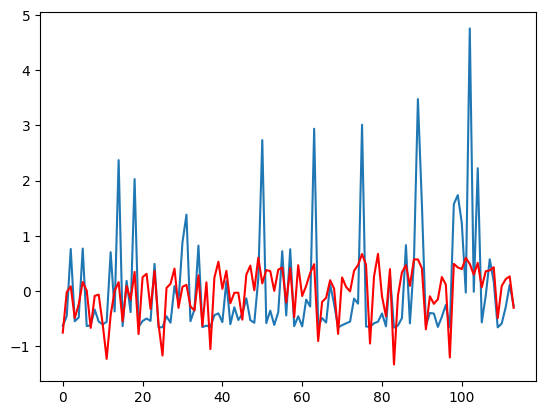

In [ ]:
fig, ax = plt.subplots()

ax.plot([i for i in range (y.shape [0]) ], y)
ax.plot([i for i in range (y.shape [0]) ], y_pred ,color ="red")
plt.show()

In [ ]:
X

,LP,LTIV,PC,Price_Decay,Price_R2,TIV_Decay,TIV_R2
0,2.345962,2.746808,-0.384678,-1.063660,0.254197,-1.007627,0.142488
1,2.251907,2.532912,0.475191,-0.279537,0.451914,-0.972083,0.538486
2,2.212676,2.233535,0.475191,-0.373456,0.491581,-0.999657,0.686106
3,2.232983,2.226602,-0.384678,-1.179355,0.985050,-1.215951,0.304615
4,2.050659,1.850519,0.475191,-0.543097,0.212593,-0.123845,-0.059673
...,...,...,...,...,...,...,...
109,-1.464310,-1.247057,-2.104417,-0.799281,0.819965,-0.915658,0.570206
110,-1.548557,-1.241678,-0.384678,-0.676969,0.425206,-0.986149,0.614444
111,-1.461041,-1.316601,0.475191,-1.362277,0.653149,-1.313418,0.456264
112,-1.375222,-1.297537,-0.384678,0.307674,-0.066945,0.098426,0.687798


In [ ]:
function_set = ['add', 'sub', 'mul', 'div',
'sqrt', 'log', 'abs', 'neg', 'inv',
'max', 'min']
#population_size=4000 , generations=100 , hall_of_fame=200 , n_components=10
gp = SymbolicTransformer(generations=100, population_size=4000,
hall_of_fame=200, n_components=10,
function_set=function_set,
parsimony_coefficient=0.0005,
max_samples=0.9, verbose=1,
random_state=0, n_jobs=3)

gp.fit(X, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.26        0.0908839        8         0.439796         0.468331      8.25m
   1     9.22         0.203486       18         0.511493         0.280209      6.86m
   2     7.38         0.289363       17         0.566133         0.537336      6.74m
   3     9.63         0.320121       19         0.600353         0.551673      8.95m
   4    13.38         0.361605       15         0.655916         0.248109      6.50m
   5    17.81         0.403424       40         0.652616         0.712272      7.41m
   6    25.32         0.448465       38         0.719564          0.58626      9.98m
   7    32.18         0.485658       38          0.73464         0.358781      8.07m
   8    41.46         0.522639       29         0.775033         0.504492  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    generations=100, hall_of_fame=200, max_samples=0.9,
                    n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=4000, random_state=0, verbose=1)

In [ ]:
gp_features = gp.transform(X)
#new_diabetes = np.hstack((diabetes.data, gp_features))

In [ ]:
gp_features

array([[ 2.83493531,  2.83493531,  2.83493531, ...,  2.83493531,
         2.83493531,  2.83493531],
       [ 5.6412105 ,  5.6412105 ,  7.13912484, ...,  4.69234312,
         7.13912484, 19.12826297],
       [ 6.80307852,  6.80307852,  8.1495752 , ...,  6.51237826,
         8.1495752 , 27.00730802],
       ...,
       [ 2.83493531,  2.83493531,  2.83493531, ...,  2.83493531,
         2.83493531,  6.24209339],
       [ 2.83493531,  2.83493531,  2.83493531, ...,  2.83493531,
         2.83493531,  2.83493531],
       [ 2.83493531,  2.83493531,  2.83493531, ...,  2.83493531,
         2.83493531,  2.83493531]])

In [ ]:
gp_features.shape

(114, 10)

In [ ]:
np.hstack((X.values, gp_features))

array([[ 2.34596186,  2.74680808, -0.3846784 , ...,  2.83493531,
         2.83493531,  2.83493531],
       [ 2.25190746,  2.5329118 ,  0.47519096, ...,  4.69234312,
         7.13912484, 19.12826297],
       [ 2.21267622,  2.23353521,  0.47519096, ...,  6.51237826,
         8.1495752 , 27.00730802],
       ...,
       [-1.46104072, -1.3166013 ,  0.47519096, ...,  2.83493531,
         2.83493531,  6.24209339],
       [-1.37522237, -1.2975368 , -0.3846784 , ...,  2.83493531,
         2.83493531,  2.83493531],
       [-1.61922311, -1.27239721, -1.24454776, ...,  2.83493531,
         2.83493531,  2.83493531]])

In [ ]:
gp_features_df = pd.DataFrame (gp_features)
gp_features_rename_dict = {}
for col in gp_features_df.columns : gp_features_rename_dict [col] = str (col) + "_"
gp_features_df.rename (gp_features_rename_dict  , axis =1 ,inplace=True)
gp_features_df

,0_,1_,2_,3_,4_,5_,6_,7_,8_,9_
0,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935
1,5.641211,5.641211,7.139125,8.576324,13.372117,3.194429,5.641211,4.692343,7.139125,19.128263
2,6.803079,6.803079,8.149575,9.084495,18.533533,5.165882,6.803079,6.512378,8.149575,27.007308
3,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935
4,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,3.473531
...,...,...,...,...,...,...,...,...,...,...
109,2.834935,2.834935,2.834935,2.834935,3.442604,2.834935,2.834935,2.834935,2.834935,2.834935
110,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935
111,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,6.242093
112,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935


In [ ]:
X = X.join (gp_features_df)
X

,LP,LTIV,PC,Price_Decay,Price_R2,TIV_Decay,TIV_R2,0_,1_,2_,3_,4_,5_,6_,7_,8_,9_
0,2.345962,2.746808,-0.384678,-1.063660,0.254197,-1.007627,0.142488,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935
1,2.251907,2.532912,0.475191,-0.279537,0.451914,-0.972083,0.538486,5.641211,5.641211,7.139125,8.576324,13.372117,3.194429,5.641211,4.692343,7.139125,19.128263
2,2.212676,2.233535,0.475191,-0.373456,0.491581,-0.999657,0.686106,6.803079,6.803079,8.149575,9.084495,18.533533,5.165882,6.803079,6.512378,8.149575,27.007308
3,2.232983,2.226602,-0.384678,-1.179355,0.985050,-1.215951,0.304615,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935
4,2.050659,1.850519,0.475191,-0.543097,0.212593,-0.123845,-0.059673,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,3.473531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-1.464310,-1.247057,-2.104417,-0.799281,0.819965,-0.915658,0.570206,2.834935,2.834935,2.834935,2.834935,3.442604,2.834935,2.834935,2.834935,2.834935,2.834935
110,-1.548557,-1.241678,-0.384678,-0.676969,0.425206,-0.986149,0.614444,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935
111,-1.461041,-1.316601,0.475191,-1.362277,0.653149,-1.313418,0.456264,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,6.242093
112,-1.375222,-1.297537,-0.384678,0.307674,-0.066945,0.098426,0.687798,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935,2.834935


In [ ]:
reg = LinearRegression().fit(X, y)
y_pred = reg.predict (X)

In [ ]:
reg.score (X,y)

0.8289280281517288

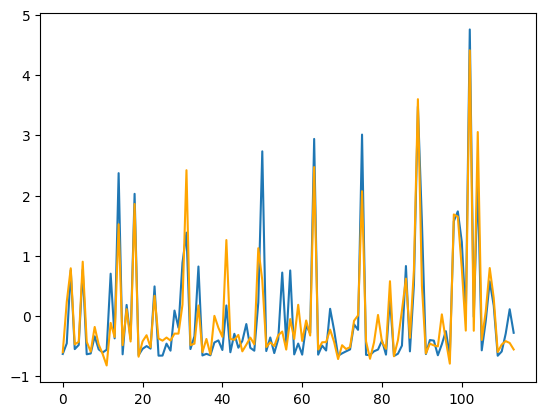

In [ ]:
fig, ax = plt.subplots()

ax.plot([i for i in range (y.shape [0]) ], y)
ax.plot([i for i in range (y.shape [0]) ], y_pred ,color ="orange")
plt.show()

In [ ]:
# Creating and training the symbolic regressor
#parsimony_coefficient=0.0001 ,  generations=50
function_set = ['add', 'sub', 'mul', 'div' , 'sqrt', 'log', 'abs', 'neg', 'inv']
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           function_set=function_set,
                           parsimony_coefficient=0.01, random_state=0,n_jobs=-1)
est_gp.fit(X, y)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.79          182.654        5         0.365739         0.773506      1.03m
   1     5.69           3.9739        5         0.402569         0.460452      1.87m
   2     4.42          2.66434        5         0.349102         0.914927      1.19m
   3     4.16          6.75042        5         0.353901          0.87413      1.08m
   4     4.72           4.8163        6         0.351292         0.744839      1.30m
   5     4.98          1.13838        5         0.332677          1.05453     58.30s
   6     4.99          1.38593        6         0.306242          1.12776     54.02s
   7     5.03         0.963332        6         0.313567           1.0655      1.10m
   8     4.98         0.972603        6         0.318236          1.02581  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                'abs', 'neg', 'inv'],
                  max_samples=0.9, n_jobs=-1, p_crossover=0.7,
                  p_hoist_mutation=0.1, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [ ]:
# Making predictions
y_pred_g = est_gp.predict(X)

# Evaluating the model
print("Model expression:", est_gp._program)
print("Mean Squared Error:", mean_squared_error(y, y_pred_g))


Model expression: log(sub(0.500, mul(0.372, X8)))
Mean Squared Error: 0.33972645650493966


In [ ]:
est_gp.score(X,y)

0.6602735434950604

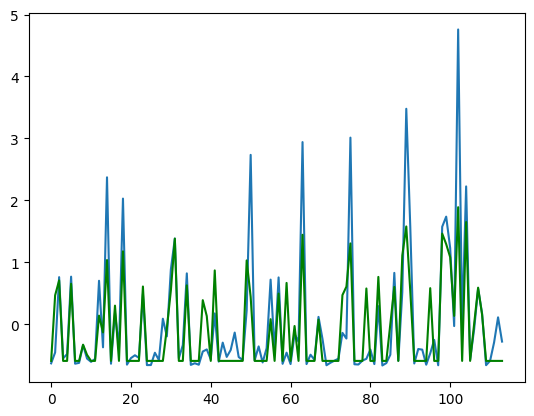

In [ ]:
fig, ax = plt.subplots()

ax.plot([i for i in range (y.shape [0]) ], y)
ax.plot([i for i in range (y.shape [0]) ], y_pred_g ,color ="green")
plt.show()

In [ ]:
X.shape [0] // number_of_test_per_fold

114

In [ ]:
kf              = KFold(n_splits=X.shape [0] // number_of_test_per_fold , shuffle= True )

fold_number     = 0

kfold_pred_dict = {fold_test_index :np.array([])  ,
                   fold_y_pred     : np.array ([]) ,
                   }

kfold_pred_list = []
model_NN = MLPRegressor(
    hidden_layer_sizes=(250, 200, 100, 100,100),  # More layers and different numbers of neurons
    activation='tanh',  # Different activation function
    solver='sgd',  # Different optimizer
    learning_rate_init=0.01,  # Initial learning rate
    learning_rate='adaptive',  # Adaptive learning rate
    max_iter=1000,  # More iterations
    batch_size=64,  # Smaller batch size
    alpha=0.0001,  # L2 regularization
    early_stopping=True,  # Enable early stopping
    n_iter_no_change=20,  # Patience for early stopping
    random_state=0
)

for i, (train_index, test_index) in enumerate(kf.split(X)):
      print(f"Fold {i}:")
      print(f"  Train: index={train_index}")
      print(f"  Test:  index={test_index}")

      X_train_fold  = X.loc [train_index]
      X_test_fold   = X.loc [test_index]

      y_train_fold  = y.loc [train_index]
      y_test_fold   = y.loc [test_index]

      reg_fold = LinearRegression().fit(X_train_fold, y_train_fold)
      #reg_fold = model_NN.fit(X_train_fold, y_train_fold)

      fold_y_pred_value = scaler_dict [Target].inverse_transform (reg_fold.predict (X_test_fold).reshape (-1,1))

      kfold_pred_dict [fold_test_index] =  test_index
      kfold_pred_dict [fold_y_pred]     =  fold_y_pred_value.reshape (-1)
      kfold_pred_dict [fold_num ]       =  i

      kfold_pred_list.append (pd.DataFrame ( kfold_pred_dict))


      print ( kfold_pred_dict)

kfold_pred_df = pd.concat (kfold_pred_list)


Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113]
  Test:  index=[81]
{'fold_test_index': array([81]), 'fold_y_pred': array([168504.42290042]), 'fold_num': 0}
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95

In [ ]:
data_input = data_input.merge (kfold_pred_df.set_index (fold_test_index) , how = "left" , left_index = True , right_index = True)
data_input

,LPB,MMC,Year,LP,LTIV,PC,Price_Decay,Price_R2,TIV_Decay,TIV_R2,Profit,Profit_Pred,fold_y_pred,fold_num
0,1000,iPhone XS Max_512GB_Verizon,2018,1029.35,656.816,19,-0.001192,0.894662,-0.001335,0.879887,41381,-90609.352312,7.829486e+04,69
1,1000,iPhone XS Max_512GB_Unlocked,2018,1014.39,634.388,20,-0.001009,0.911918,-0.001326,0.918513,227473,686927.540627,1.114159e+06,11
2,1000,iPhone XS Max_256GB_Unlocked,2018,1008.15,602.997,20,-0.001031,0.915380,-0.001333,0.932912,1514777,798169.040720,1.552876e+06,76
3,1000,iPhone X_256GB_Verizon,2017,1011.38,602.270,19,-0.001220,0.958448,-0.001388,0.895701,126462,187927.083180,2.176870e+05,84
4,900,iPhone XS Max_256GB_Verizon,2018,982.38,562.836,20,-0.001070,0.891031,-0.001114,0.860168,199737,452581.196094,2.588948e+05,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,400,iPhone 7_256GB_T-Mobile,2016,423.30,238.041,17,-0.001130,0.944040,-0.001312,0.921607,9867,186207.969502,8.212208e+04,17
110,400,iPhone 7_128GB_T-Mobile,2016,409.90,238.605,19,-0.001102,0.909587,-0.001330,0.925922,84340,804095.285727,2.134184e+05,33
111,400,iPhone 7_32GB_AT&T,2016,423.82,230.749,20,-0.001262,0.929481,-0.001412,0.910493,397857,935394.716618,2.564460e+05,102
112,400,iPhone 7 Plus_32GB_T-Mobile,2016,437.47,232.748,19,-0.000871,0.866634,-0.001058,0.933077,827457,988928.418168,1.924627e+05,34


In [ ]:
kfold_pred_df.shape

(114, 3)

In [ ]:
kfold_pred_df [fold_test_index].duplicated().sum ()

0

<Axes: xlabel='Profit', ylabel='fold_y_pred'>

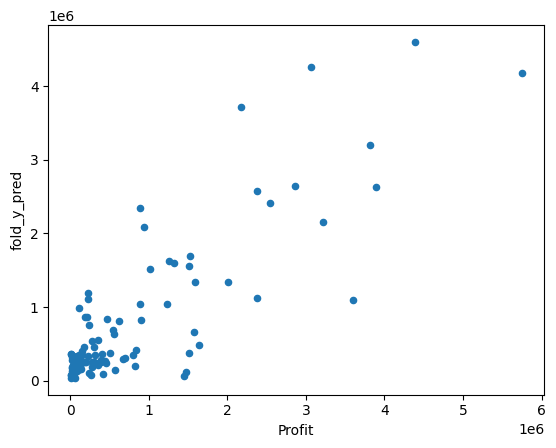

In [ ]:
data_input [(data_input [fold_y_pred] < data_input [Target].max() ) *
            (data_input [fold_y_pred] > data_input [Target].min() )
             ].plot.scatter (Target , fold_y_pred)